In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

### PART I - Solving the simulation


#### Governing equation for beam bending

In [ ]:
from __future__ import division
from sympy import *

x, y, b_w, b_f, h, E, L, p, k = symbols('x y b_w b_f h E L p k')
C1,C2,C3,C4 = symbols('C1 C2 C3 C4')

u = Function('u')

b = (b_f-b_w)*(2/h)**2*y**2+b_w

A = integrate(b,(y, -h/2,h/2))
Q = integrate(b*y,(y, y, h/2))
I = integrate(b*y**2,(y, -h/2,h/2))
eq = E*I*Derivative(Derivative(u(x),x,x),x,x)-(-4*p/L**2)*x*(x-L)

display(eq)

display('h=')
display(h)
display('b=')
display(b)

display('A=')
display(A)
display('Q=')
display(Q)
display('I=')
display(I)

E*(b_w*h**3/12 + h**3*(4*b_f - 4*b_w)/80)*Derivative(u(x), (x, 4)) + 4*p*x*(-L + x)/L**2

'h='

h

'b='

b_w + 4*y**2*(b_f - b_w)/h**2

'A='

b_w*h + h*(4*b_f - 4*b_w)/12

'Q='

b_w*h**2/8 - b_w*y**2/2 + h**2*(b_f - b_w)/16 - y**4*(b_f - b_w)/h**2

'I='

b_w*h**3/12 + h**3*(4*b_f - 4*b_w)/80

#### Generic solution

In [ ]:
u=dsolve(eq,u(x)).rhs

display(u)

C1 + C2*x + C3*x**2 + C4*x**3 + 2*p*x**5/(E*L*h**3*(3*b_f + 2*b_w)) - 2*p*x**6/(3*E*L**2*h**3*(3*b_f + 2*b_w))

#### Boundary conditions

In [ ]:
du    = u.diff(x)
ddu   = u.diff(x,x)
dddu  = u.diff(x,x,x)

bc1 = u.subs(x,0)
bc2 = du.subs(x,0)
bc3 = u.subs(x,L)
bc4 = du.subs(x,L)

In [ ]:
from sympy.solvers.solveset import linsolve

sol=linsolve([bc1, bc2, bc3, bc4], (C1,C2,C3,C4))
[C1sol,C2sol,C3sol,C4sol] = list(sol)[0]


In [ ]:
usol= u.subs([(C1,C1sol), (C2,C2sol), (C3,C3sol), (C4,C4sol)]) # displacement

Msol   = E*I*diff(usol,x,x)   # Moment
Vsol   = E*I*diff(usol,x,x,x) # Shear

sigmaxx=(Msol * y) / I
sigmaxy=(Vsol * Q) / (b*I)
sigmavm = sigmaxx**2+3*sigmaxy**2     # von mises stress

Note that such equations are tedious for humans to not make a mistake, but trivial for computers to keep track of

### Part II 

We set both $t_\mathrm{f}$ and $t_\mathrm{w}$ as optimization variables, we aim to minimize the weight of structure while keeping 

Substituting in values for plotting

\begin{equation}
\begin{aligned}
\min_{h,b_\mathrm{w}} \quad & \mathrm{A(y) L \rho}\\
\textrm{s.t.} \quad & \sigma_\mathrm{vm}^2-\sigma_\mathrm{y}^2 < 0\\
& u_\mathrm{max}-u_\mathrm{limit} < 0\\
& b_\mathrm{w}-b_\mathrm{min} < 0\\
& h-h_\mathrm{min} < 0\\
\end{aligned}
\end{equation}

In [ ]:
# Defining parameters
valE      = 200e9 # Pa
valL      = 15    # m
valk      = 5e6   # Pa
valb_f    = 0.25   # m
valp      = -20000 # N/m
valrho    = 7800 #kg/m^3

ASub      = A.subs(      [(b_f, valb_f) ])
uSub      = usol.subs(   [(E,valE), (b_f, valb_f),(L,valL),(p,valp),(x,valL/2)  ])
sigmaSub0 = sigmavm.subs([(b_f, valb_f),(L,valL),(p,valp),(x,0),      (y,h/2)])
sigmaSub1 = sigmavm.subs([(b_f, valb_f),(L,valL),(p,valp),(x,valL/2), (y,-h/2)])
sigmaSub2 = sigmavm.subs([(b_f, valb_f),(L,valL),(p,valp),(x,0),      (y,0)])
sigmaSub3 = sigmavm.subs([(b_f, valb_f),(L,valL),(p,valp),(x,valL/4), (y,h/4)])


In [ ]:

u_max     = valL/250
valSigmaY = 180e6 # Pa

h_min     = 0.01
h_max     = 0.5

b_min     = 0.01
b_max     = valb_f

# Displacement function and its derivatives
AFun        = lambdify([h,b_w], ASub)
uFun        = lambdify([h,b_w], uSub)
sigmaFun0   = lambdify([h,b_w], sigmaSub0)
sigmaFun1   = lambdify([h,b_w], sigmaSub1)
sigmaFun2   = lambdify([h,b_w], sigmaSub2)
sigmaFun3   = lambdify([h,b_w], sigmaSub3)

n = 500

var_h   = np.linspace(0.0001, h_max, n)
var_b_w = np.linspace(0.0001, b_max, n)

optVar_h, optVar_b_w = np.meshgrid(var_h, var_b_w)
display(uSub)
ANum       = AFun     (optVar_h, optVar_b_w)
uNum       = uFun     (optVar_h, optVar_b_w)
sigmaNum0  = sigmaFun0(optVar_h, optVar_b_w)
sigmaNum1  = sigmaFun1(optVar_h, optVar_b_w)
sigmaNum2  = sigmaFun2(optVar_h, optVar_b_w)
sigmaNum3  = sigmaFun3(optVar_h, optVar_b_w)

1265625000.0/(1200000000000.0*b_w*h**3 + 450000000000.0*h**3) - 506250000.0/(400000000000.0*b_w*h**3 + 150000000000.0*h**3) - 0.000263671875/(h**3*(2*b_w + 0.75))

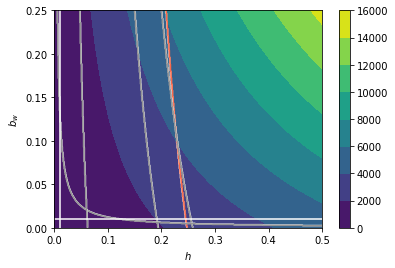

In [ ]:
plt.contourf(optVar_h, optVar_b_w, ANum*valL*valrho, cmap='viridis')
plt.colorbar()

plt.plot([0.,   h_max], [h_min,h_min], 'white')
plt.plot([b_min,b_min], [0.,   b_max], 'white')

plt.contour(optVar_h, optVar_b_w, np.sign(uNum+u_max), 1, cmap='Reds')
plt.contour(optVar_h, optVar_b_w, np.sign(sigmaNum0 - valSigmaY**2), 1, cmap='Greys')
plt.contour(optVar_h, optVar_b_w, np.sign(sigmaNum1 - valSigmaY**2), 1, cmap='Greys')
plt.contour(optVar_h, optVar_b_w, np.sign(sigmaNum2 - valSigmaY**2), 1, cmap='Greys')
plt.contour(optVar_h, optVar_b_w, np.sign(sigmaNum3 - valSigmaY**2), 1, cmap='Greys')

plt.xlabel(r'$h$')
plt.ylabel(r'$b_w$')

plt.xlim([0.,h_max])
plt.ylim([0.,b_max])

plt.show()